Michael Woodburn

This code is an implementation of a Long-Short Term Memory, a special kind of RNN, which is designed to forecast time series.

By running the code on timeseries which capture the number of confirmed cases of coronavirus in each country vs time, I'm seeking to train it to predict the next 3 days of coronavirus cases.

Given the limited accuracy of the LSTM for this data, I decided to test it on the last three known values (up to the 13th of March) which were witheld during training.

It achieved modest accuracy.

# Corona Virus

* Coronaviruses are **zoonotic** viruses (means transmitted between animals and people).  
* Symptoms include from fever, cough, respiratory symptoms, and breathing difficulties. 
* In severe cases, it can cause pneumonia, severe acute respiratory syndrome (SARS), kidney failure and even death.
* Coronaviruses are also asymptomatic, means a person can be a carrier for the infection but experiences no symptoms

# Novel coronavirus (nCoV)
* A **novel coronavirus (nCoV)** is a new strain that has not been previously identified in humans.

# COVID-19 (Corona Virus Disease 2019)
* Caused by a **SARS-COV-2** corona virus.  
* First identified in **Wuhan, Hubei, China**. Earliest reported symptoms reported in **November 2019**. 
* First cases were linked to contact with the Huanan Seafood Wholesale Market, which sold live animals. 
* On 30 January the WHO declared the outbreak to be a Public Health Emergency of International Concern 

# Acknowledgements

> https://github.com/CSSEGISandData/COVID-19

# Collection methodology

> https://github.com/imdevskp/covid_19_jhu_data_web_scrap_and_cleaning

# Libraries

### Install

### Import

In [1]:
# essential libraries
import json
import random
from urllib.request import urlopen

# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import calmap
import folium

# color pallette
cnf = '#393e46' # confirmed - grey
dth = '#ff2e63' # death - red
rec = '#21bf73' # recovered - cyan
act = '#fe9801' # active case - yellow

# converter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()   

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# html embedding
from IPython.display import Javascript
from IPython.core.display import display
from IPython.core.display import HTML

In [2]:
%matplotlib inline

# Dataset

In [3]:
# list files
# !ls ../input/corona-virus-report

In [4]:
# importing datasets
full_table = pd.read_csv('input/covid_19_clean_complete.csv', 
                         parse_dates=['Date'])
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Thailand,15.0000,101.0000,2020-01-22,2,0,0
1,NaN,Japan,36.0000,138.0000,2020-01-22,2,0,0
2,NaN,Singapore,1.2833,103.8333,2020-01-22,0,0,0
3,NaN,Nepal,28.1667,84.2500,2020-01-22,0,0,0
4,NaN,Malaysia,2.5000,112.5000,2020-01-22,0,0,0


In [5]:
#dataframe info
full_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11960 entries, 0 to 11959
Data columns (total 8 columns):
Province/State    5876 non-null object
Country/Region    11960 non-null object
Lat               11960 non-null float64
Long              11960 non-null float64
Date              11960 non-null datetime64[ns]
Confirmed         11960 non-null int64
Deaths            11960 non-null int64
Recovered         11960 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 747.6+ KB


In [6]:
# checking for missing value
full_table.isna().sum()

Province/State    6084
Country/Region       0
Lat                  0
Long                 0
Date                 0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

# Preprocessing

### Cleaning Data

In [7]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table[cases] = full_table[cases].fillna(0)

In [8]:
full_table.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,,Thailand,15.0000,101.0000,2020-01-22,2,0,0,2
1,,Japan,36.0000,138.0000,2020-01-22,2,0,0,2
2,,Singapore,1.2833,103.8333,2020-01-22,0,0,0,0
3,,Nepal,28.1667,84.2500,2020-01-22,0,0,0,0
4,,Malaysia,2.5000,112.5000,2020-01-22,0,0,0,0


I want to create a predictive model which forecasts the number of cases at each lattitude on a given day.

In [9]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# This relates to plotting datetime values with matplotlib:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
Confirmed_Time = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum()
Confirmed_Time = Confirmed_Time.reset_index().sort_values(by=['Date', 'Country/Region'])

In [12]:
series_list = []
series_dict = {}

i = 0
for CountryRegion in Confirmed_Time['Country/Region'].unique():
    series_dict[i] = CountryRegion
    series = Confirmed_Time[Confirmed_Time['Country/Region']==CountryRegion][['Date','Confirmed']]
    series.rename(columns={"Date": "ds",'Confirmed':'y'},inplace=True)
    series_list.append(series)
    i+=1

In [18]:
y = np.array([series['y'].values for series in series_list])

In [22]:
y_scale = np.log(y+1)

In [24]:
# Define a test size
test_size = 3

# Create train and test sets
train_set = y_scale[:,:-test_size]
test_set = y_scale[:,-test_size:]

In [27]:
ws = 5

In [26]:
def input_data(seq,ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [28]:
X_train = []
Y_train = []
for seq in train_set:
    out = input_data(seq,ws)
    for series in out:
        X_train.append(series[0])
        Y_train.append(series[1])

In [32]:
Y_train = np.array(Y_train)

In [35]:
X_train = np.array(X_train)

In [36]:
len(X_train)

5500

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [41]:
X_train_train, X_val, y_train_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42)

In [42]:
regressor = LinearRegression().fit(X_train_train,y_train_train)

In [43]:
regressor.score(X_train_train,y_train_train)

0.9858884557929742

In [44]:
regressor.score(X_val,y_val)

0.9934913404655632

In [45]:
preds = regressor.predict(X_val)

In [49]:
y_val

array([[ 0.69314718],
       [10.43737519],
       [ 0.        ],
       ...,
       [ 0.        ],
       [ 0.69314718],
       [ 0.        ]])

In [51]:
mean_squared_error(y_val,preds)

0.02190053737239575

In [52]:
true_preds = np.exp(preds)

In [53]:
true_y_val = np.exp(y_val)

In [55]:
mean_squared_error(true_y_val,true_preds)

794653.0349275777

This RMSQE is quite a lot higher than the NN. I believe that the long runs of 0s are throwing this regressor off. Let's try a neural network.

In [56]:
from sklearn.neural_network import MLPRegressor

In [67]:
NN  = MLPRegressor(max_iter=2000, hidden_layer_sizes = (100,10,), learning_rate_init=0.01, learning_rate = 'constant', 
                  early_stopping = True, n_iter_no_change = 200)

In [68]:
NN.fit(X_train_train,y_train_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(100, 10), learning_rate='constant',
             learning_rate_init=0.01, max_iter=2000, momentum=0.9,
             n_iter_no_change=200, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [69]:
NN.n_iter_

208

In [70]:
NN.score(X_train_train,y_train_train)

0.9863183023049794

In [71]:
preds = NN.predict(X_val)
print('MSE', mean_squared_error(y_val,preds))
true_preds = np.exp(preds)
true_y_val = np.exp(y_val)
print('MSE true', mean_squared_error(true_y_val,true_preds))

MSE 0.021769861385517595
MSE true 14678.25838489247


Wow, is this really a massive improvement on my former predictions?

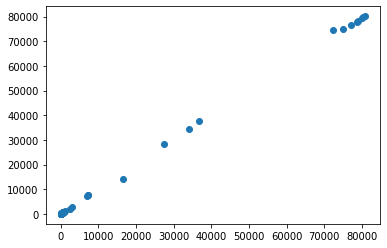

In [72]:
plt.scatter(true_y_val,true_preds)

That actually looks great! Let's see what it does on novel data.

In [94]:
X_test_final = train_set[:,-5:]


In [95]:
X_test_final_copy = X_test_final

In [96]:
preds = []
for i in range(3):
    Y_test_final = test_set[:,i]
    preds_final = NN.predict(X_test_final)
    print('MSE', mean_squared_error(Y_test_final,preds_final))
    true_preds_final = np.exp(preds_final)
    true_y_test_final = np.exp(Y_test_final)
    print('MSE true', mean_squared_error(true_y_test_final,true_preds_final))
    
    
    X_test_final = np.concatenate([X_test_final,preds_final.reshape(125,1)],axis=1)
    X_test_final = X_test_final[:,-5:]
    preds.append(true_preds_final)
    
    

MSE 0.14524325489532008
MSE true 9512.820904287026
MSE 0.17930700228125218
MSE true 42837.272870251225
MSE 0.4850235833877598
MSE true 157372.6459004765


In [120]:
preds_rect = np.array(preds).T

In [121]:
np.exp(test_set)[:5]

array([[ 8.,  8.,  8.],
       [13., 24., 34.],
       [21., 25., 27.],
       [ 2.,  2.,  2.],
       [ 1.,  1.,  2.]])

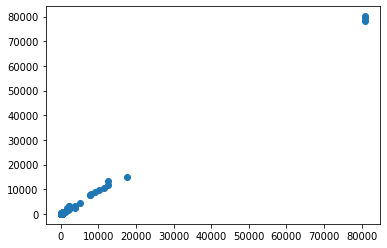

In [123]:
plt.scatter(np.exp(test_set),preds_rect)

I'm really impressed by this result. It looks like that with appropriate log preprocessing using a log scale, the neural network achieves very high accuracy.

Checking the overall error

In [125]:
print('MSE true', mean_squared_error(test_set.ravel(),preds_rect.ravel()))

MSE true 53097498.41845444
